In [1]:
%matplotlib inline


# Two-class AdaBoost


This example fits an AdaBoosted decision stump on a non-linearly separable
classification dataset composed of two "Gaussian quantiles" clusters
(see :func:`sklearn.datasets.make_gaussian_quantiles`) and plots the decision
boundary and decision scores. The distributions of decision scores are shown
separately for samples of class A and B. The predicted class label for each
sample is determined by the sign of the decision score. Samples with decision
scores greater than zero are classified as B, and are otherwise classified
as A. The magnitude of a decision score determines the degree of likeness with
the predicted class label. Additionally, a new dataset could be constructed
containing a desired purity of class B, for example, by only selecting samples
with a decision score above some value.

Author: Noel Dawe <noel.dawe@gmail.com>
License: BSD 3 clause

Adaptiert durch B.Tödtli <beat.toedtli@ffhs.ch>

In [159]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_gaussian_quantiles

In [160]:
#make_gaussian_quantiles?

In [161]:
# Construct train dataset
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=1000, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=1500, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))


In [162]:
#?train_test_split
Xtrain,Xvalid,ytrain,yvalid=train_test_split(X,y,test_size=0.2)
Xtrain.shape,Xvalid.shape,ytrain.shape,yvalid.shape

((2000, 2), (500, 2), (2000,), (500,))

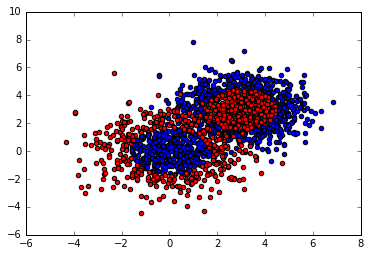

In [163]:
plt.scatter(Xtrain[ytrain==0,0],Xtrain[ytrain==0,1],c='b')
plt.scatter(Xtrain[ytrain==1,0],Xtrain[ytrain==1,1],c='r');

** Aufgabe** 
- Untersuchen Sie den Effekt von n_estimators (und max_depth) in der nächsten Zelle.
Der Erfinder von Adaboost hat diese Frage auch untersucht. Hier ist seine Antwort:
http://rob.schapire.net/papers/explaining-adaboost.pdf

-  Warum ergibt sich nur für ungerade Werte von n_estimators jeweils eine Änderung?

In [180]:
def plotDecisionBoundaries(bagging_or_boosting,n_estimators,Xtrain,ytrain,plot_step = 0.02,
                           plot_colors = "br",class_names = "AB",max_depth=1):
    if bagging_or_boosting=='boosting':
    # Create and fit an AdaBoosted decision tree
        bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                             algorithm="SAMME",
                             n_estimators=n_estimators)
    elif bagging_or_boosting=='bagging':
        # Create and fit an bagged decision tree
        bdt = BaggingClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                 n_estimators=n_estimators)
    

    bdt.fit(Xtrain, ytrain)

    # Plot the decision boundaries
    x_min, x_max = Xtrain[:, 0].min() - 1, Xtrain[:, 0].max() + 1
    y_min, y_max = Xtrain[:, 1].min() - 1, Xtrain[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis("tight")

    # Plot the training points
    for i, n, c in zip(range(2), class_names, plot_colors):
        plt.scatter(Xtrain[ytrain==i, 0], Xtrain[ytrain == i, 1],
                    c=c, cmap=plt.cm.Paired,s=10,edgecolors='none',
                    label="Class %s" % n)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(loc='upper right')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Decision Boundary, {0} decision trees of depth 1'.format(bagging_or_boosting));
    
    return bdt

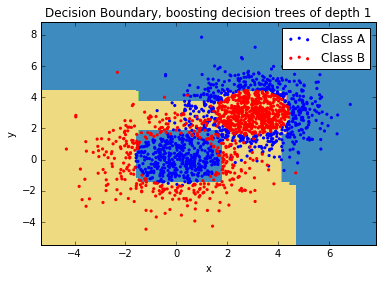

In [175]:
n_estimators=30
plotDecisionBoundaries('boosting',n_estimators,Xtrain,ytrain);

In [176]:
from sklearn.metrics import accuracy_score

trainErrorList=[]
validationErrorList=[]

n_estimator_list=range(10,500,50)
for n_estimators in n_estimator_list:
    # Create and fit an AdaBoosted decision tree
    bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                             algorithm="SAMME",
                             n_estimators=n_estimators)

    bdt.fit(Xtrain, ytrain)
    
    yhattrain=bdt.predict(Xtrain)
    yhat_val=bdt.predict(Xvalid)
    
    train_error=1-accuracy_score(yhattrain,ytrain)
    val_error=1-accuracy_score(yhat_val,yvalid)
    
    
    trainErrorList.append(train_error)
    validationErrorList.append(val_error)

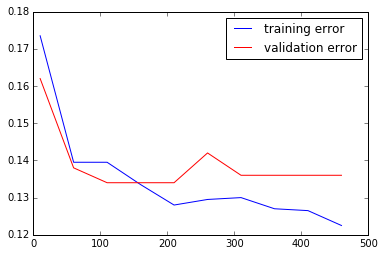

In [177]:
plt.plot(n_estimator_list,trainErrorList,'b',label='training error')
plt.plot(n_estimator_list,validationErrorList,'r',label='validation error')
plt.legend();

Vergleichen Sie noch mit dem Cleveland-Datensatz, welcher nicht künstlich erzeugt ist

Als nächstes

In [178]:
#Siehe http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
estimator=bdt.estimators_[0]
n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold
n_nodes,children_left,children_right,feature,threshold

(3,
 array([ 1, -1, -1]),
 array([ 2, -1, -1]),
 array([ 0, -2, -2]),
 array([ 4.42309093, -2.        , -2.        ]))

Offenbar ist das erste Element in diesen 1x3-Arrays immer der Knoten, welche nicht ein Blatt (leaf, Knoten ohne Kindsnknoten) ist. Damit können wir die einzelnen Bäume als Linien einzeichnen:

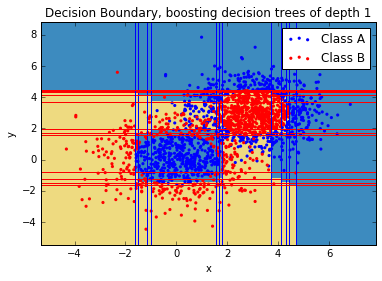

In [179]:
n_estimators=50 #Versuchen Sie auch 500
bdt=plotDecisionBoundaries('boosting',n_estimators,Xtrain,ytrain)
for est in bdt.estimators_:
    th = est.tree_.threshold[0]
    if est.tree_.feature[0]==0:
        #print('x-th {0:+1.2f}'.format(th))
        plt.plot([th,th],plt.ylim(),'b')
    else:
        #print('y-th {0:+1.2f}'.format(th))
        plt.plot(plt.xlim(),[th,th],'r')

**Aufgabe**
- Diskutieren Sie den Effekt von Adaboost in diesem Beispiel
- Versuchen Sie, zu verallgemeinern: Wie wirk Adaboost im Fall von anderen Klassifikatoren als dem Decision-"Stump" (horizontale und vertikale Schwellwertklassifikatoren)?
- Wie würde ein Bagging von Decision-Stumps in diesem Fall wirken?

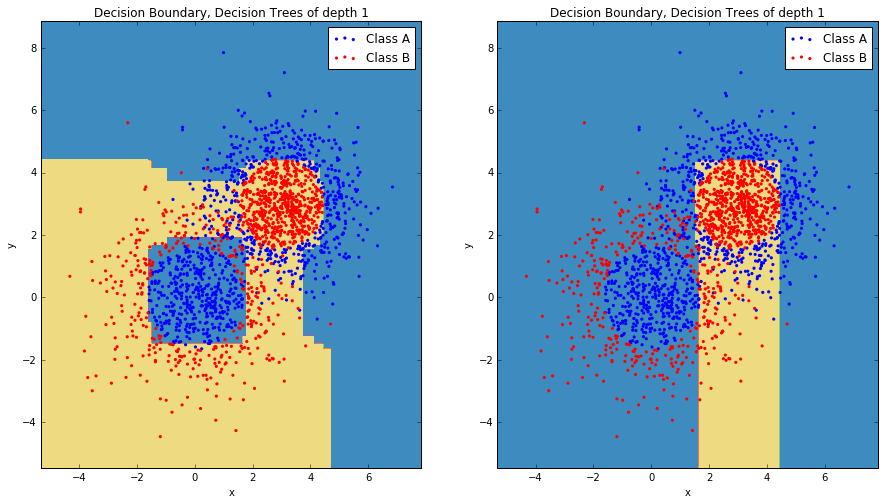

In [173]:
n_estimators=50
plt.figure(1,figsize=(15,8))
plt.subplot(1,2,1);
plotDecisionBoundaries('boosting',n_estimators,Xtrain,ytrain);
plt.subplot(1,2,2)
plotDecisionBoundaries('bagging',n_estimators,Xtrain,ytrain);

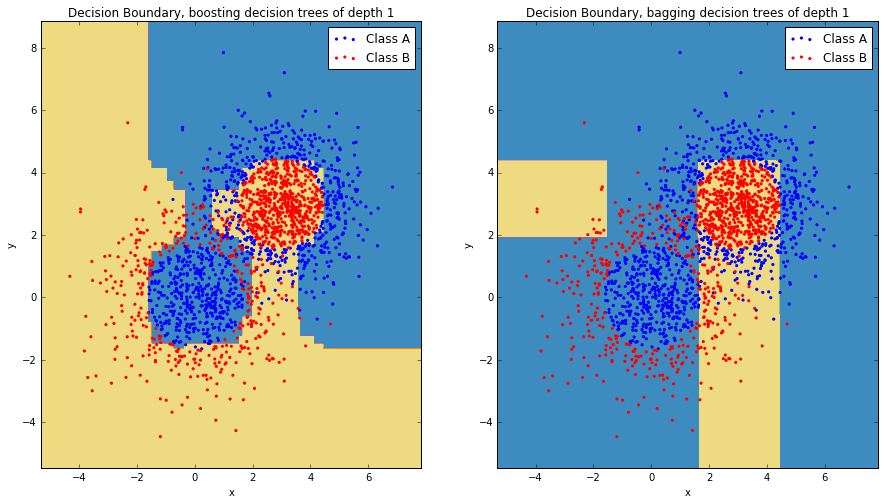

In [183]:
n_estimators=50
plt.figure(1,figsize=(15,8))
plt.subplot(1,2,1);
plotDecisionBoundaries('boosting',n_estimators,Xtrain,ytrain,max_depth=2);
plt.subplot(1,2,2)
plotDecisionBoundaries('bagging',n_estimators,Xtrain,ytrain,max_depth=2);